[View in Colaboratory](https://colab.research.google.com/github/eltiotino/darwins/blob/master/20181017_rackpub2.ipynb)

In [1]:
#carga todas las librerias en colab
%pylab inline
!pip install pandas-datareader
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import numpy.random as rng
import pandas_datareader.data as web
import numpy as np
import pandas as pd
!pip install ta
import ta
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data as pdr
!pip install fix_yahoo_finance
!pip install ffn
import fix_yahoo_finance as yf
import ffn
yf.pdr_override() # Importamos Pandas Datareader y lo parcheamos para que funcione con Yahoo


Populating the interactive namespace from numpy and matplotlib


In [0]:

def strategy_performance(stock,periodo):  
    #stock = pdr.get_data_yahoo(stock_ticker, start="2008-01-01", end="2018-10-01")         
    
    
    #Compute periodo -days breakout and mean.

    # 5-days high  
    stock['high'] = stock['Adj Close'].shift(1).rolling(window=periodo).max()  
    # 5-days low  
    stock['low'] = stock['Adj Close'].shift(1).rolling(window=periodo).min()  
    # 5-days mean  
    stock['avg'] = stock['Adj Close'].shift(1).rolling(window=periodo).mean()  

    #Entry Rules
    #When the closing price of the stock is greater than the high of past 55 days 
    #then we go long on the stock and 
    #when the closing price of the stock is less than the low of past 55 days 
    #then we go short on the stock.

    stock['long_entry'] = stock['Adj Close'] > stock.high         
    stock['short_entry'] = stock['Adj Close'] < stock.low  

    #stock['signal']=np.where(stock['Adj Close'] > stock.high,1,np.nan)
    
    #stock['signal']=np.where(stock['Adj Close'] < stock.low,1,stock['signal'])
    #Exit Rules

    #We will exit the positions if the stock price crosses the mean of past 55 days.

    stock['long_exit'] = stock['Adj Close'] < stock.avg  
    stock['short_exit'] = stock['Adj Close'] > stock.avg  

    #stock['signal']=np.where(stock['Adj Close'].shift() > stock.avg.shift(),0,stock['signal'])
    #stock['signal']=np.where(stock['Adj Close'].shift() < stock.avg.shift(),0,stock['signal'])

    
    #Positions
    
    #We will now store the entry and exit signal in a single column. Long position is indicated by 1, short position is indicated by -1 and exit or no position is indicated by 0. We will carry forward the previous position if no position exists for a time period using the fillna method.

    stock['positions_long'] = np.nan    
    stock.loc[stock.long_entry,'positions_long']= 1    
    stock.loc[stock.long_exit,'positions_long']= 0    
    
    stock['positions_short'] = np.nan    
    stock.loc[stock.short_entry,'positions_short']= 0    
    stock.loc[stock.short_exit,'positions_short']= 0    
  
    stock['Signal'] = stock.positions_long + stock.positions_short  
  
    stock= stock.fillna(method='ffill')   
    #stock=stock.fillna(0,inplace=True)
    
    #print(stock)
    #Strategy Returns
    
    #We have computed the log returns of the stock and multiplied with the Signal (1,-1 or 0) to get the strategy returns.

    daily_log_returns = np.log(stock['Adj Close']/stock['Adj Close'].shift(1))  
    daily_log_returns = daily_log_returns * stock.Signal.shift(1)  
  
    # Plot the distribution of 'daily_log_returns'  
    #print (stock)  
    daily_log_returns.hist(bins=50)  
    plt.show()  
    return daily_log_returns.cumsum() 



In [0]:
def var95m2(valuados,graph=True,box=True,imp=True,time='M'):
    #pasamos las cotizaciones a mensual
    memo=valuados.resample(time).last()
    #ploteamos
    #calculamos el % cambio
    mempct=memo.pct_change()
    #calculamos el t_test
    #print "t test mensual\n\n",mempct.mean()/(mempct.std()/math.sqrt(len(mempct)))
    #calculamos el var95
    #print "var95 \n\n",mempct.quantile(.05)
    #mempct.plot()
    t_test=(mempct.mean()/(mempct.std()/math.sqrt(len(mempct))))
    
    agg_measures = {
        'avg': mempct.mean(),
        'std': mempct.std(),
        'var': mempct.var(),
        'med': mempct.median(),
        '01p': mempct.quantile(.01),
        '05p': mempct.quantile(.05),
        '50p': mempct.quantile(.50),
        '95p': mempct.quantile(.95),
        'val': mempct.quantile(.95)/mempct.quantile(.05),
        'skw': mempct.skew(),
        'kur': mempct.kurtosis(),
        'T-test': t_test
    }
    
    if graph==True :
        plt.close()
        memo.plot()
        plt.show()
        mempct.plot()
        #mempct.hist(bins=40,normed=True,alpha=0.7)
        #x=np.linspace(agg_measures['avg']-3*agg_measures['std'],agg_measures['avg']+3*agg_measures['std'],100)
        #plt.plot(x,mlab.normpdf(x,agg_measures['avg'],agg_measures['std']),'b')
        plt.show()
    if box==True:   
        mempct2=pd.DataFrame(mempct)
        mempct2.boxplot(vert=False,rot=90)
        plt.show()
        del mempct2
    if imp==True:
        for n in sorted(agg_measures.keys()):
            koko=" el valor de {} es : {:2.5} ".format(n,agg_measures[n])
            print (koko)
       
    
    return agg_measures 
    

In [0]:
def ma_crossover(values,larga=20,corta=10):
#     import talib as ta
    df=pd.DataFrame()
    #print type(values)
    df['base']=values.copy()
    #print df.base.tail()
    df['logvalues']=np.log(df.base / df.base.shift(1))
    df['mediacorta']=df.base.rolling(corta).mean()
#     df['mediacorta']=ta.MA(df.base.values,corta,0)
    #print df.mediacorta.tail(20)
    df['medialarga']=df.base.rolling(larga).mean()
#     df['medialarga']=ta.MA(df.base.values,larga,0)
    #print df.medialarga.tail(20)
    #df[['base','medialarga','mediacorta']].plot(figsize=(16,9))
    df['senal']=np.where(df.mediacorta>df.medialarga,1,-1)
    df['senal']=df['senal'].fillna(0)
    #df.senal.plot(secondary_y=True)
    #print df.logvalues
    df['rendimiento']=df.senal.shift()*df.logvalues
    df['rendimiento']=df['rendimiento'].fillna(0)
    df['rendimiento'][0]=np.log(df['base'][0])
    df['serie']=np.exp(df.rendimiento.cumsum())
    
    return df.serie

*****   MMM     ******
[*********************100%***********************]  1 of 1 downloaded


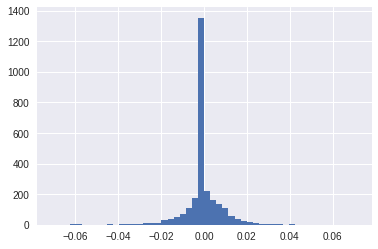

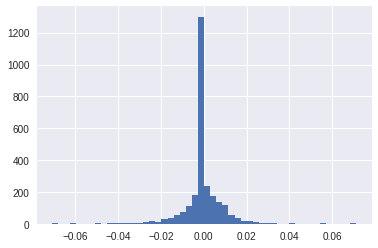

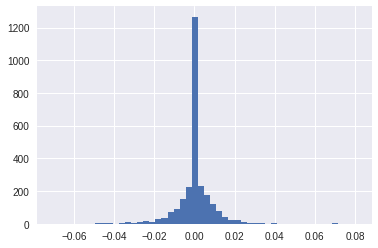

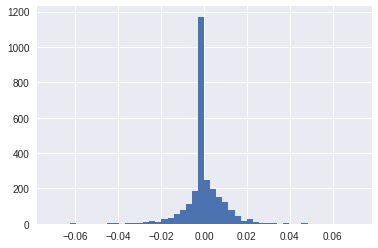

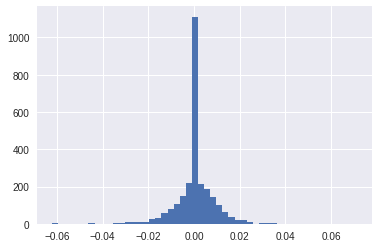

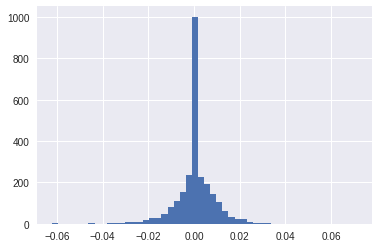

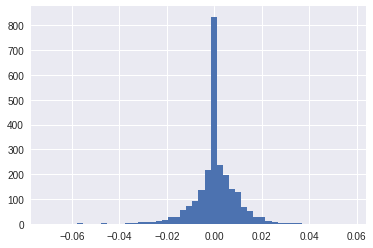

*****   GOOG     ******
[*********************100%***********************]  1 of 1 downloaded


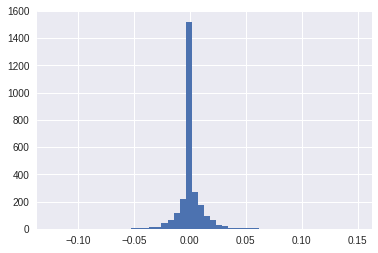

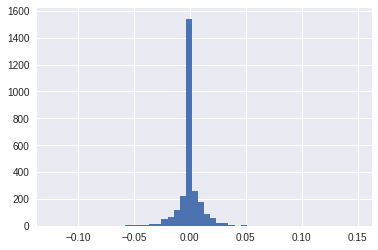

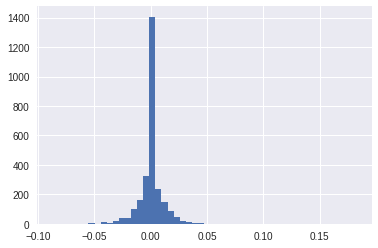

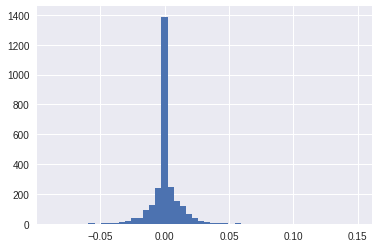

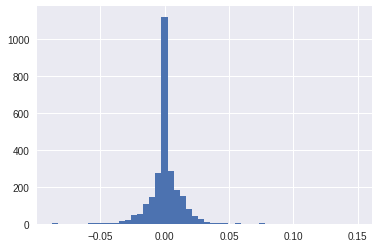

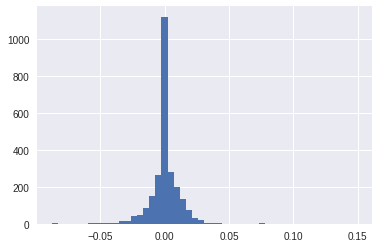

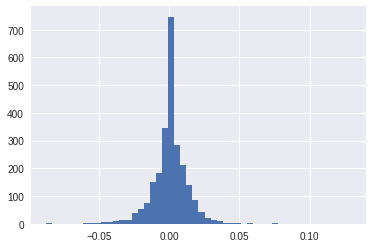

*****   xlu     ******
[*********************100%***********************]  1 of 1 downloaded


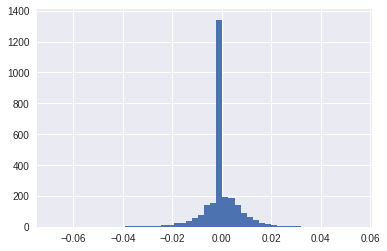

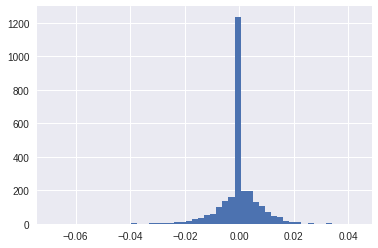

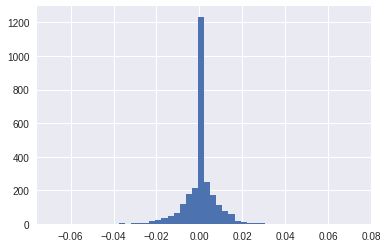

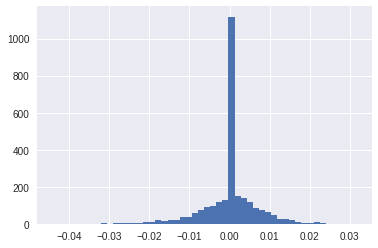

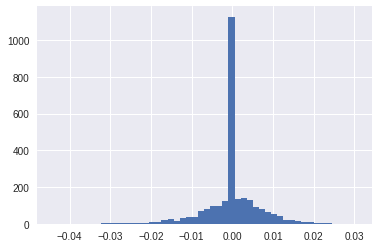

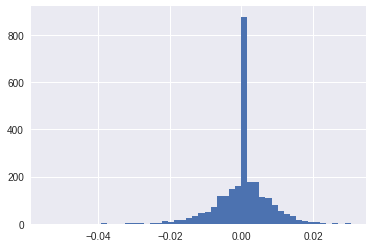

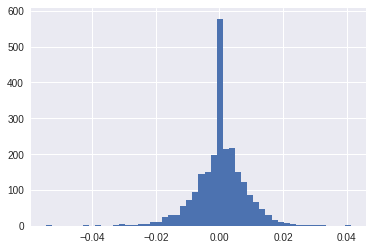

*****   AAPL     ******
[*********************100%***********************]  1 of 1 downloaded


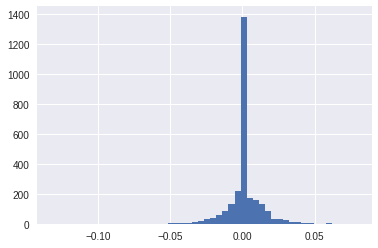

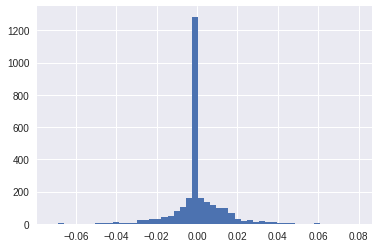

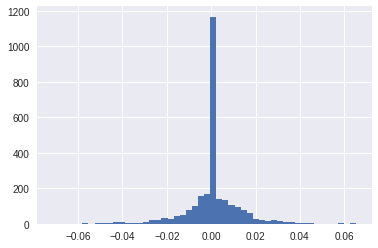

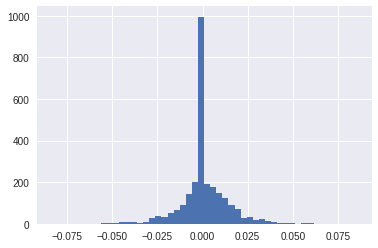

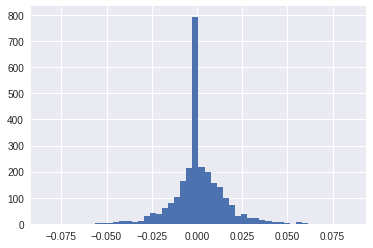

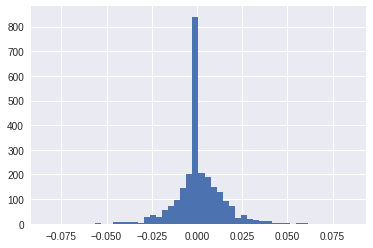

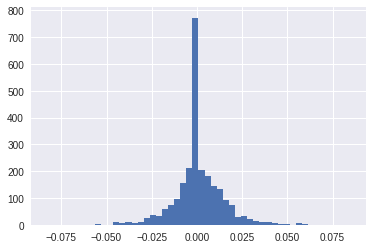

In [5]:

#Step 3: Create a portfolio of stocks and calculate the strategy performance for each stock.

portfolio = ['AAPL','KMI','F','GOOG','AMZN']
portfolio = ['MMM','GOOG','xlu','AAPL']
#portfolio = ['tef.mc','san.mc','itx.mc','rep.mc']

periodos = [ 5, 10 , 20 , 40 ,60, 110, 220]
#portfolio = ['QQQ']
#periodos = [ 5]
cum_daily_log_return = pd.DataFrame()  
#Cargamos los datos desde yahoo

#creamos la serie terminada en _l + periodo
#Obtenemos los datos en log %

for stock in portfolio:   
  print ('*****  ',stock,'    ******')
  pstock = pdr.get_data_yahoo(stock, start="2008-01-01", end="2018-10-01")         

  for periodo in periodos:
    nombre='{}_l{}'.format(stock,periodo)
    cum_daily_log_return[nombre] = strategy_performance(pstock,periodo)  

# Plot the cumulative daily returns  
#print ("Cumulative Daily Returns")  
#cum_daily_log_return.plot()  
# Show the plot  
#plt.show()  

In [6]:
#Pasamos los datos como serie

cum_daily_return=np.exp(cum_daily_log_return)
#print (cum_daily_return.tail())
print (cum_daily_return.columns)

Index(['MMM_l5', 'MMM_l10', 'MMM_l20', 'MMM_l40', 'MMM_l60', 'MMM_l110',
       'MMM_l220', 'GOOG_l5', 'GOOG_l10', 'GOOG_l20', 'GOOG_l40', 'GOOG_l60',
       'GOOG_l110', 'GOOG_l220', 'xlu_l5', 'xlu_l10', 'xlu_l20', 'xlu_l40',
       'xlu_l60', 'xlu_l110', 'xlu_l220', 'AAPL_l5', 'AAPL_l10', 'AAPL_l20',
       'AAPL_l40', 'AAPL_l60', 'AAPL_l110', 'AAPL_l220'],
      dtype='object')


In [0]:
#extrae los rendimientos de 3 meses para todas las estrategias
#rel_cum_daily_return=cum_daily_return.pct_change(60).fillna(0)

In [0]:
#plotea los 500 ultimos valores de la series
#rel_cum_daily_return[-500:].plot()

In [0]:
#plotea todos los valores
#cum_daily_return.pct_change(60).plot(figsize=(18,8))

In [0]:
#grafica los valores en funcion del periodod
portfolio_grupo={}
cum_daily_return['neutro']=0.00000001
cum_daily_return['neutro_l5']=0.000001
cum_daily_return['neutro_l10']=0.000001
cum_daily_return['neutro_l20']=0.000001
cum_daily_return['neutro_l60']=0.000001
cum_daily_return['neutro_l110']=0.000001
cum_daily_return['neutro_l220']=0.000001

for periodo in periodos:

    f1=pd.DataFrame(index=cum_daily_return.index)
    #print ('Grafico del periodo',periodo)
    l5=cum_daily_return.filter(like='_l{}'.format(periodo),axis=1).columns.values
    #l4='neutro'
    #l5=np.append(l5,l4)
    portfolio_grupo[periodo]=dict(periodo=l5)
      
#    for periodo2 in periodos:

        #f1=pd.DataFrame(index=cum_daily_return.index)
        #print ('Grafico del periodo',periodo)
        #l5=cum_daily_return.filter(like='_l{}'.format(periodo),axis=1).columns.values
#        cum_daily_return[l5].pct_change(periodo2).plot(figsize=(16,8),title='grafico en {} y pct {}'.format(periodo,periodo2))

In [11]:
#obiene las series por periodo
portfolio_grupo[5]['periodo']



array(['MMM_l5', 'GOOG_l5', 'xlu_l5', 'AAPL_l5', 'neutro_l5'],
      dtype=object)

In [12]:
'''
cum_daily_return[portfolio_grupo[220]['periodo']].pct_change(60).plot()
cum_daily_return['pepe']=cum_daily_return[portfolio_grupo[220]['periodo']].pct_change(110).apply(lambda x: x.argmax(), axis=1)
print (cum_daily_return['pepe'].tail())
print (cum_daily_return[portfolio_grupo[220]['periodo']].pct_change(110).tail())
'''

"\ncum_daily_return[portfolio_grupo[220]['periodo']].pct_change(60).plot()\ncum_daily_return['pepe']=cum_daily_return[portfolio_grupo[220]['periodo']].pct_change(110).apply(lambda x: x.argmax(), axis=1)\nprint (cum_daily_return['pepe'].tail())\nprint (cum_daily_return[portfolio_grupo[220]['periodo']].pct_change(110).tail())\n"

In [13]:
resultados= []
for periodo in periodos:
  for periodo2 in periodos:
    nombre='resultado_{}d{}p'.format(periodo,periodo2)
    resultados.append(nombre)
    cum_daily_return[nombre]=cum_daily_return[portfolio_grupo[periodo]['periodo']].pct_change(periodo2).apply(lambda x: x.argmax(), axis=1)
    #hay que poner el pct_change


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  


In [0]:
#cum_daily_return


In [14]:
#tenemos neutro y nada mas
"""
f1=pd.DataFrame(index=cum_daily_return.index)
l5=cum_daily_return.filter(like='neutro'.format(periodo),axis=1).columns.values
cum_daily_return[l5].plot(figsize=(16,8))
"""

"\nf1=pd.DataFrame(index=cum_daily_return.index)\nl5=cum_daily_return.filter(like='neutro'.format(periodo),axis=1).columns.values\ncum_daily_return[l5].plot(figsize=(16,8))\n"

In [0]:
#calcula los retornos en log

f1=pd.DataFrame(index=cum_daily_return.index)
l5=cum_daily_return.filter(like='_l'.format(periodo),axis=1).columns.values
for fila in l5:
  nombre='p_'+fila
  cum_daily_return[nombre]=np.log(cum_daily_return[fila]/cum_daily_return[fila].shift())

In [16]:
"""
print (portfolio)
print (resultados)
print (periodos)
print (periodos)
"""

'\nprint (portfolio)\nprint (resultados)\nprint (periodos)\nprint (periodos)\n'

In [0]:
for periodo in periodos:
  for periodo2 in periodos:
    nombre='res_{}d{}p'.format(periodo,periodo2)
    nombre2='resultado_{}d{}p'.format(periodo,periodo2)
    cum_daily_return[nombre]=np.zeros(len(cum_daily_return))

    for numbre in portfolio:
      nombre3='{}_l{}'.format(numbre,periodo)
      nombre4='p_{}_l{}'.format(numbre,periodo2)
      cum_daily_return[nombre]=np.where(cum_daily_return[nombre2].shift()==nombre3,cum_daily_return[nombre4],cum_daily_return[nombre])


In [0]:
#print (cum_daily_return['res_220d60p'].tail())
#print (periodo)

In [0]:
f1=pd.DataFrame(index=cum_daily_return.index)
l5=cum_daily_return.filter(like='res_',axis=1).columns
for fila in l5:
  nombre='serie_'+fila
  cum_daily_return[nombre]=np.exp(cum_daily_return[fila].cumsum())
  

In [0]:
#cum_daily_return[l5]

In [21]:

f1=pd.DataFrame(index=cum_daily_return.index)
l5=cum_daily_return.filter(like='serie_',axis=1).columns
"""
cum_daily_return[l5].plot(figsize=(16,8))
"""

'\ncum_daily_return[l5].plot(figsize=(16,8))\n'

In [22]:
"""
cum_daily_return['serie_res_110d60p'].plot()
cum_daily_return[portfolio_grupo[220]['periodo']].pct_change(60).plot()
"""


"\ncum_daily_return['serie_res_110d60p'].plot()\ncum_daily_return[portfolio_grupo[220]['periodo']].pct_change(60).plot()\n"

In [23]:
"""
f1=pd.DataFrame(index=cum_daily_return.index)
l5=cum_daily_return.filter(like='serie_res_5'.format(periodo),axis=1).columns.values
cum_daily_return[l5].plot(figsize=(16,8))
"""

"\nf1=pd.DataFrame(index=cum_daily_return.index)\nl5=cum_daily_return.filter(like='serie_res_5'.format(periodo),axis=1).columns.values\ncum_daily_return[l5].plot(figsize=(16,8))\n"

In [24]:
"""
f1=pd.DataFrame(index=cum_daily_return.index)
l5=cum_daily_return.filter(like='serie_res_10'.format(periodo),axis=1).columns.values
cum_daily_return[l5].plot(figsize=(16,8))
"""


"\nf1=pd.DataFrame(index=cum_daily_return.index)\nl5=cum_daily_return.filter(like='serie_res_10'.format(periodo),axis=1).columns.values\ncum_daily_return[l5].plot(figsize=(16,8))\n"

In [25]:
"""
f1=pd.DataFrame(index=cum_daily_return.index)
l5=cum_daily_return.filter(like='serie_res_20'.format(periodo),axis=1).columns.values
cum_daily_return[l5].plot(figsize=(16,8))
"""

"\nf1=pd.DataFrame(index=cum_daily_return.index)\nl5=cum_daily_return.filter(like='serie_res_20'.format(periodo),axis=1).columns.values\ncum_daily_return[l5].plot(figsize=(16,8))\n"

In [26]:
"""
f1=pd.DataFrame(index=cum_daily_return.index)
l5=cum_daily_return.filter(like='serie_res_60'.format(periodo),axis=1).columns.values
cum_daily_return[l5].plot(figsize=(16,8))
"""

"\nf1=pd.DataFrame(index=cum_daily_return.index)\nl5=cum_daily_return.filter(like='serie_res_60'.format(periodo),axis=1).columns.values\ncum_daily_return[l5].plot(figsize=(16,8))\n"

In [27]:
"""
f1=pd.DataFrame(index=cum_daily_return.index)
l5=cum_daily_return.filter(like='serie_res_110'.format(periodo),axis=1).columns.values
cum_daily_return[l5].plot(figsize=(16,8))
"""

"\nf1=pd.DataFrame(index=cum_daily_return.index)\nl5=cum_daily_return.filter(like='serie_res_110'.format(periodo),axis=1).columns.values\ncum_daily_return[l5].plot(figsize=(16,8))\n"

In [28]:
"""
f1=pd.DataFrame(index=cum_daily_return.index)
l5=cum_daily_return.filter(like='serie_res_220'.format(periodo),axis=1).columns.values
cum_daily_return[l5].plot(figsize=(16,8))
"""

"\nf1=pd.DataFrame(index=cum_daily_return.index)\nl5=cum_daily_return.filter(like='serie_res_220'.format(periodo),axis=1).columns.values\ncum_daily_return[l5].plot(figsize=(16,8))\n"

In [29]:
print(l5)
perf=cum_daily_return[l5].dropna().calc_stats()
#perf.plot()


Index(['serie_res_5d5p', 'serie_res_5d10p', 'serie_res_5d20p',
       'serie_res_5d40p', 'serie_res_5d60p', 'serie_res_5d110p',
       'serie_res_5d220p', 'serie_res_10d5p', 'serie_res_10d10p',
       'serie_res_10d20p', 'serie_res_10d40p', 'serie_res_10d60p',
       'serie_res_10d110p', 'serie_res_10d220p', 'serie_res_20d5p',
       'serie_res_20d10p', 'serie_res_20d20p', 'serie_res_20d40p',
       'serie_res_20d60p', 'serie_res_20d110p', 'serie_res_20d220p',
       'serie_res_40d5p', 'serie_res_40d10p', 'serie_res_40d20p',
       'serie_res_40d40p', 'serie_res_40d60p', 'serie_res_40d110p',
       'serie_res_40d220p', 'serie_res_60d5p', 'serie_res_60d10p',
       'serie_res_60d20p', 'serie_res_60d40p', 'serie_res_60d60p',
       'serie_res_60d110p', 'serie_res_60d220p', 'serie_res_110d5p',
       'serie_res_110d10p', 'serie_res_110d20p', 'serie_res_110d40p',
       'serie_res_110d60p', 'serie_res_110d110p', 'serie_res_110d220p',
       'serie_res_220d5p', 'serie_res_220d10p', 'serie_r

/usr/local/lib/python3.6/dist-packages/ffn/core.py:2056: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)


In [0]:
#perf.display_monthly_returns()

In [0]:
datos=[ 'total_return', 'cagr', 'max_drawdown', 'calmar', \
        'daily_sharpe', 'daily_sortino', \
        'monthly_sharpe', 'monthly_sortino', 'best_month', \
       'worst_month', 'yearly_sharpe',  'best_year', 'worst_year', \
       'avg_drawdown', 'avg_drawdown_days', 'avg_up_month', 'avg_down_month', \
       'win_year_perc', 'twelve_month_win_perc']

In [32]:
resultados=perf.stats.T
#print (resultados.columns)
resultados[datos][resultados.cagr>.2]


,total_return,cagr,max_drawdown,calmar,daily_sharpe,daily_sortino,monthly_sharpe,monthly_sortino,best_month,worst_month,yearly_sharpe,best_year,worst_year,avg_drawdown,avg_drawdown_days,avg_up_month,avg_down_month,win_year_perc,twelve_month_win_perc
serie_res_10d110p,6.50172,0.206431,-0.19286,1.07037,1.07693,1.82709,1.19555,2.7359,0.188311,-0.120424,1.16443,0.5839,0.0216261,-0.0321102,29.1869,0.0495327,-0.0232953,1,0.830508
serie_res_10d220p,6.45457,0.205723,-0.320417,0.642046,0.984706,1.66161,1.0093,2.3176,0.200422,-0.120859,1.45839,0.484643,-0.00723707,-0.0349561,30.13,0.0579119,-0.0311021,0.9,0.79661
serie_res_110d110p,8.27228,0.230475,-0.317964,0.724845,1.12264,1.91454,1.11512,2.41454,0.200422,-0.196584,1.04232,0.758332,-0.161968,-0.0357931,28.5413,0.0593132,-0.0304596,0.8,0.847458
serie_res_110d220p,10.9101,0.2595,-0.250333,1.03662,1.19414,2.02411,1.2658,3.08666,0.188311,-0.1076,1.64306,0.530679,-0.0525172,-0.0332467,23.7724,0.0626788,-0.0287682,0.9,0.864407
serie_res_220d110p,6.49791,0.206374,-0.251327,0.821137,1.05087,1.74289,1.05673,2.21579,0.200422,-0.196584,1.21352,0.494965,-0.0577286,-0.0341084,28.3394,0.0542912,-0.0298842,0.8,0.830508
serie_res_220d40p,11.7373,0.267401,-0.232014,1.15252,1.31222,2.26992,1.41454,3.60232,0.204381,-0.143956,1.16516,0.974102,0.0145858,-0.0288345,26.2583,0.0534455,-0.0253076,1,0.898305
serie_res_40d220p,6.97502,0.213324,-0.285154,0.748103,1.01308,1.67619,1.02033,2.22682,0.188311,-0.116677,1.49176,0.530679,0.0248014,-0.0369838,26.7838,0.0626046,-0.0354031,1,0.830508
serie_res_40d5p,6.54071,0.207013,-0.173294,1.19458,1.09794,1.8978,1.16016,2.71634,0.188311,-0.111957,0.938668,0.568584,-0.0393162,-0.0315271,28.2033,0.0528897,-0.0314582,0.8,0.872881
serie_res_5d110p,7.87828,0.225509,-0.314721,0.716537,1.12014,1.90681,1.14939,2.66709,0.200422,-0.145231,1.19672,0.612459,-0.168284,-0.0307204,24.2857,0.0574493,-0.0263506,0.9,0.872881
serie_res_5d220p,6.64941,0.208623,-0.294897,0.707444,1.01347,1.66663,1.06603,2.23296,0.188311,-0.145231,1.73393,0.456755,0.0473176,-0.0296892,26.75,0.0568245,-0.0312036,1,0.847458


In [33]:
resultados[datos][resultados.monthly_sharpe>.9]

,total_return,cagr,max_drawdown,calmar,daily_sharpe,daily_sortino,monthly_sharpe,monthly_sortino,best_month,worst_month,yearly_sharpe,best_year,worst_year,avg_drawdown,avg_drawdown_days,avg_up_month,avg_down_month,win_year_perc,twelve_month_win_perc
serie_res_10d110p,6.50172,0.206431,-0.19286,1.07037,1.07693,1.82709,1.19555,2.7359,0.188311,-0.120424,1.16443,0.5839,0.0216261,-0.0321102,29.1869,0.0495327,-0.0232953,1,0.830508
serie_res_10d220p,6.45457,0.205723,-0.320417,0.642046,0.984706,1.66161,1.0093,2.3176,0.200422,-0.120859,1.45839,0.484643,-0.00723707,-0.0349561,30.13,0.0579119,-0.0311021,0.9,0.79661
serie_res_110d110p,8.27228,0.230475,-0.317964,0.724845,1.12264,1.91454,1.11512,2.41454,0.200422,-0.196584,1.04232,0.758332,-0.161968,-0.0357931,28.5413,0.0593132,-0.0304596,0.8,0.847458
serie_res_110d220p,10.9101,0.2595,-0.250333,1.03662,1.19414,2.02411,1.2658,3.08666,0.188311,-0.1076,1.64306,0.530679,-0.0525172,-0.0332467,23.7724,0.0626788,-0.0287682,0.9,0.864407
serie_res_110d40p,5.95647,0.197982,-0.196691,1.00657,1.01112,1.7183,1.09149,2.38078,0.188311,-0.143956,1.41713,0.600069,-0.000758315,-0.0335728,32.3267,0.055053,-0.0268134,0.9,0.864407
serie_res_110d60p,4.2438,0.166862,-0.216487,0.770773,0.883594,1.45049,0.914822,1.96172,0.188311,-0.133199,0.731923,0.8952,-0.159303,-0.0360659,35.6517,0.0535301,-0.0312153,0.8,0.754237
serie_res_20d10p,3.92788,0.160129,-0.364964,0.438754,0.906803,1.49517,1.00516,2.37339,0.188311,-0.114032,0.781953,0.789773,-0.114931,-0.0332101,43.012,0.0536487,-0.0344194,0.8,0.762712
serie_res_20d40p,4.655,0.175095,-0.26264,0.666673,0.954297,1.58168,0.994937,2.19842,0.188311,-0.108673,0.932577,0.39857,-0.089583,-0.0341855,38.8901,0.0520963,-0.0272183,0.7,0.779661
serie_res_20d5p,4.91121,0.179954,-0.361905,0.497241,0.976391,1.60395,1.08689,2.38769,0.188311,-0.109132,0.980821,0.780271,-0.00541176,-0.0287791,32.3945,0.0505462,-0.0342463,0.9,0.822034
serie_res_220d10p,5.88766,0.196874,-0.369453,0.532879,1.15376,1.93368,1.02904,2.58312,0.187132,-0.0984785,0.859616,0.689154,-0.14775,-0.0331298,35.587,0.0605686,-0.0298729,0.8,0.737288


In [34]:
resultados[datos][resultados.twelve_month_win_perc>.8]

,total_return,cagr,max_drawdown,calmar,daily_sharpe,daily_sortino,monthly_sharpe,monthly_sortino,best_month,worst_month,yearly_sharpe,best_year,worst_year,avg_drawdown,avg_drawdown_days,avg_up_month,avg_down_month,win_year_perc,twelve_month_win_perc
serie_res_10d110p,6.50172,0.206431,-0.19286,1.07037,1.07693,1.82709,1.19555,2.7359,0.188311,-0.120424,1.16443,0.5839,0.0216261,-0.0321102,29.1869,0.0495327,-0.0232953,1,0.830508
serie_res_110d110p,8.27228,0.230475,-0.317964,0.724845,1.12264,1.91454,1.11512,2.41454,0.200422,-0.196584,1.04232,0.758332,-0.161968,-0.0357931,28.5413,0.0593132,-0.0304596,0.8,0.847458
serie_res_110d220p,10.9101,0.2595,-0.250333,1.03662,1.19414,2.02411,1.2658,3.08666,0.188311,-0.1076,1.64306,0.530679,-0.0525172,-0.0332467,23.7724,0.0626788,-0.0287682,0.9,0.864407
serie_res_110d40p,5.95647,0.197982,-0.196691,1.00657,1.01112,1.7183,1.09149,2.38078,0.188311,-0.143956,1.41713,0.600069,-0.000758315,-0.0335728,32.3267,0.055053,-0.0268134,0.9,0.864407
serie_res_20d20p,3.2736,0.14484,-0.348182,0.41599,0.819924,1.35771,0.799561,1.85443,0.201085,-0.104956,0.801182,0.388705,-0.181331,-0.0402358,41.9294,0.0593613,-0.0360322,0.7,0.805085
serie_res_20d5p,4.91121,0.179954,-0.361905,0.497241,0.976391,1.60395,1.08689,2.38769,0.188311,-0.109132,0.980821,0.780271,-0.00541176,-0.0287791,32.3945,0.0505462,-0.0342463,0.9,0.822034
serie_res_220d110p,6.49791,0.206374,-0.251327,0.821137,1.05087,1.74289,1.05673,2.21579,0.200422,-0.196584,1.21352,0.494965,-0.0577286,-0.0341084,28.3394,0.0542912,-0.0298842,0.8,0.830508
serie_res_220d40p,11.7373,0.267401,-0.232014,1.15252,1.31222,2.26992,1.41454,3.60232,0.204381,-0.143956,1.16516,0.974102,0.0145858,-0.0288345,26.2583,0.0534455,-0.0253076,1,0.898305
serie_res_220d5p,3.21219,0.143298,-0.345942,0.414226,0.83196,1.29973,0.829115,1.73148,0.171549,-0.115432,0.863863,0.383234,-0.214327,-0.0376871,38.3908,0.0508239,-0.0321052,0.9,0.838983
serie_res_40d220p,6.97502,0.213324,-0.285154,0.748103,1.01308,1.67619,1.02033,2.22682,0.188311,-0.116677,1.49176,0.530679,0.0248014,-0.0369838,26.7838,0.0626046,-0.0354031,1,0.830508


In [35]:

resultados[datos][resultados.win_year_perc==1]

,total_return,cagr,max_drawdown,calmar,daily_sharpe,daily_sortino,monthly_sharpe,monthly_sortino,best_month,worst_month,yearly_sharpe,best_year,worst_year,avg_drawdown,avg_drawdown_days,avg_up_month,avg_down_month,win_year_perc,twelve_month_win_perc
serie_res_10d110p,6.50172,0.206431,-0.19286,1.07037,1.07693,1.82709,1.19555,2.7359,0.188311,-0.120424,1.16443,0.5839,0.0216261,-0.0321102,29.1869,0.0495327,-0.0232953,1,0.830508
serie_res_220d40p,11.7373,0.267401,-0.232014,1.15252,1.31222,2.26992,1.41454,3.60232,0.204381,-0.143956,1.16516,0.974102,0.0145858,-0.0288345,26.2583,0.0534455,-0.0253076,1,0.898305
serie_res_40d220p,6.97502,0.213324,-0.285154,0.748103,1.01308,1.67619,1.02033,2.22682,0.188311,-0.116677,1.49176,0.530679,0.0248014,-0.0369838,26.7838,0.0626046,-0.0354031,1,0.830508
serie_res_40d40p,5.2791,0.186607,-0.372988,0.500304,0.937521,1.58134,1.0038,2.34608,0.197013,-0.143956,1.35982,0.524096,0.0361373,-0.0330683,30.2105,0.0556656,-0.0287645,1,0.805085
serie_res_5d220p,6.64941,0.208623,-0.294897,0.707444,1.01347,1.66663,1.06603,2.23296,0.188311,-0.145231,1.73393,0.456755,0.0473176,-0.0296892,26.75,0.0568245,-0.0312036,1,0.847458
serie_res_60d40p,4.66516,0.175291,-0.333497,0.525616,0.932613,1.51335,0.935605,1.95229,0.197013,-0.143956,1.18839,0.603629,0.0259138,-0.0321294,33.3981,0.0559798,-0.0347467,1,0.805085


In [36]:
"""
cum_daily_return['res_5d60p']=0
cum_daily_return['res_5d60p']=np.where(cum_daily_return['resultado_60d60p'].shift()=='AMZN_l60',cum_daily_return['p_AMZN_l60'],cum_daily_return['res_5d60p'])
cum_daily_return['res_5d60p']=np.where(cum_daily_return['resultado_60d60p'].shift()=='F_l60',cum_daily_return['p_F_l60'],cum_daily_return['res_5d60p'])
cum_daily_return['res_5d60p']=np.where(cum_daily_return['resultado_60d60p'].shift()=='GOOG_l60',cum_daily_return['p_GOOG_l60'],cum_daily_return['res_5d60p'])
cum_daily_return['res_5d60p']=np.where(cum_daily_return['resultado_60d60p'].shift()=='AAPL_l60',cum_daily_return['p_AAPL_l60'],cum_daily_return['res_5d60p'])
cum_daily_return['res_5d60p']=np.where(cum_daily_return['resultado_60d60p'].shift()=='KMI_l60',cum_daily_return['p_KMI_l60'],cum_daily_return['res_5d60p'])
"""

"\ncum_daily_return['res_5d60p']=0\ncum_daily_return['res_5d60p']=np.where(cum_daily_return['resultado_60d60p'].shift()=='AMZN_l60',cum_daily_return['p_AMZN_l60'],cum_daily_return['res_5d60p'])\ncum_daily_return['res_5d60p']=np.where(cum_daily_return['resultado_60d60p'].shift()=='F_l60',cum_daily_return['p_F_l60'],cum_daily_return['res_5d60p'])\ncum_daily_return['res_5d60p']=np.where(cum_daily_return['resultado_60d60p'].shift()=='GOOG_l60',cum_daily_return['p_GOOG_l60'],cum_daily_return['res_5d60p'])\ncum_daily_return['res_5d60p']=np.where(cum_daily_return['resultado_60d60p'].shift()=='AAPL_l60',cum_daily_return['p_AAPL_l60'],cum_daily_return['res_5d60p'])\ncum_daily_return['res_5d60p']=np.where(cum_daily_return['resultado_60d60p'].shift()=='KMI_l60',cum_daily_return['p_KMI_l60'],cum_daily_return['res_5d60p'])\n"



---

# Seleccionar el ratio de Sharpe que se desea 
ACTUALMENTE 0.9

In [0]:
seleccion = [x for x in resultados[datos][resultados.monthly_sharpe>.9].T]

In [38]:
#seleccion.append('neutro')
print (seleccion)

['serie_res_10d110p', 'serie_res_10d220p', 'serie_res_110d110p', 'serie_res_110d220p', 'serie_res_110d40p', 'serie_res_110d60p', 'serie_res_20d10p', 'serie_res_20d40p', 'serie_res_20d5p', 'serie_res_220d10p', 'serie_res_220d110p', 'serie_res_220d20p', 'serie_res_220d220p', 'serie_res_220d40p', 'serie_res_220d60p', 'serie_res_40d10p', 'serie_res_40d220p', 'serie_res_40d40p', 'serie_res_40d5p', 'serie_res_5d110p', 'serie_res_5d220p', 'serie_res_5d40p', 'serie_res_60d40p', 'serie_res_60d5p']


In [0]:
#1.- calculamos los retoenos en log

cum_diario_log_retornos = pd.DataFrame()  
for stock in seleccion:     

    nombre='{}_l'.format(stock)
    cum_diario_log_retornos[nombre] =    np.log(cum_daily_return[stock]/cum_daily_return[stock].shift(1))


In [40]:
cum_diario_log_retornos.tail()


,serie_res_10d110p_l,serie_res_10d220p_l,serie_res_110d110p_l,serie_res_110d220p_l,serie_res_110d40p_l,serie_res_110d60p_l,serie_res_20d10p_l,serie_res_20d40p_l,serie_res_20d5p_l,serie_res_220d10p_l,...,serie_res_220d60p_l,serie_res_40d10p_l,serie_res_40d220p_l,serie_res_40d40p_l,serie_res_40d5p_l,serie_res_5d110p_l,serie_res_5d220p_l,serie_res_5d40p_l,serie_res_60d40p_l,serie_res_60d5p_l
Date,,,,,,,,,,,,,,,,,,,,,
2018-09-24,0.014278,0.014278,0.014278,0.014278,0.014278,0.014278,-0.013121,0.014278,-0.013121,0.006224,...,0.014278,-0.013121,0.000000,0.014278,-0.013121,0.014278,0.014278,0.014278,0.014278,-0.013121
2018-09-25,0.006321,0.006321,0.006321,0.006321,0.006321,0.006321,0.000000,0.006321,-0.013533,0.000000,...,0.006321,0.000000,0.006321,0.006321,-0.013533,0.006321,0.006321,0.006321,0.006321,-0.013533
2018-09-26,-0.007998,-0.007998,-0.007998,-0.007998,-0.007998,-0.007998,-0.003518,-0.007998,-0.007998,-0.003518,...,-0.007998,-0.003518,-0.007998,-0.007998,-0.007998,-0.007998,-0.007998,-0.007998,-0.007998,-0.003518
2018-09-27,0.020343,0.020343,0.020343,0.020343,0.020343,0.020343,-0.004559,0.020343,0.020343,0.011915,...,0.020343,-0.004559,0.020343,0.020343,0.020343,0.020343,0.020343,0.020343,0.020343,0.020343
2018-09-28,0.003506,0.003506,0.003506,0.003506,0.003506,0.003506,0.002852,0.003506,0.003506,-0.000980,...,0.003506,0.002852,0.003506,0.003506,0.003506,0.003506,0.003506,0.003506,0.003506,0.003506


In [41]:
cum_diario=cum_daily_return[seleccion]
resultados= []
for periodo in periodos:
    nombre='suma_{}p'.format(periodo)
    resultados.append(nombre)
    cum_daily_return[nombre]=cum_daily_return[seleccion].pct_change(periodo).apply(lambda x: x.argmax(), axis=1)
    #hay que poner el pct_change

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  


In [42]:
resultados
#cum_daily_return[resultados].tail()

['suma_5p',
 'suma_10p',
 'suma_20p',
 'suma_40p',
 'suma_60p',
 'suma_110p',
 'suma_220p']

In [43]:
cum_daily_return[resultados]

,suma_5p,suma_10p,suma_20p,suma_40p,suma_60p,suma_110p,suma_220p
Date,,,,,,,
2008-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-09,serie_res_10d110p,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-10,serie_res_10d110p,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-11,serie_res_10d110p,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-14,serie_res_10d110p,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
for periodo in periodos:
    nombre='sumatorio_{}p'.format(periodo)
    nombre2='suma_{}p'.format(periodo)
    cum_daily_return[nombre]=np.zeros(len(cum_daily_return))

    for numbre in seleccion:
      nombre3='{}'.format(numbre)
      nombre4='{}_l'.format(numbre)
      cum_daily_return[nombre]=np.where(cum_daily_return[nombre2].shift()==nombre3,cum_diario_log_retornos[nombre4],cum_daily_return[nombre])


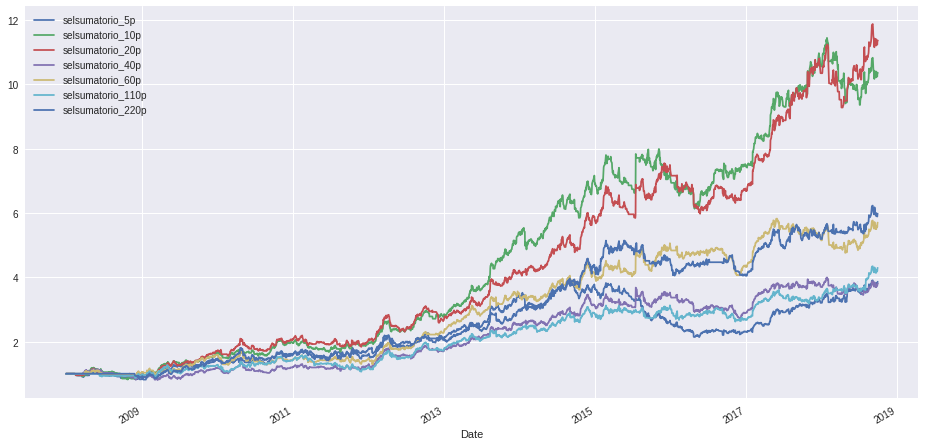

In [45]:
selsuma=[x for x  in cum_daily_return.filter(like='sumatorio',axis=1).columns]
selsumados=[ 'sel{}'.format(x) for x  in cum_daily_return.filter(like='sumatorio',axis=1).columns]

for row in selsuma:
  cum_daily_return['sel{}'.format(row)]=np.exp(cum_daily_return[row].cumsum().fillna(0))
  
cum_daily_return[selsumados].plot(figsize=(16,8))

In [0]:
perf=cum_daily_return[selsumados].dropna().calc_stats()


In [47]:
resultados=perf.stats.T
#print (resultados.columns)
resultados[datos][resultados.cagr>.1]


,total_return,cagr,max_drawdown,calmar,daily_sharpe,daily_sortino,monthly_sharpe,monthly_sortino,best_month,worst_month,yearly_sharpe,best_year,worst_year,avg_drawdown,avg_drawdown_days,avg_up_month,avg_down_month,win_year_perc,twelve_month_win_perc
selsumatorio_10p,9.35708,0.243219,-0.307497,0.790964,1.16779,1.94779,1.16868,2.65422,0.188311,-0.170353,0.917364,0.954548,-0.0203204,-0.0326679,26.4692,0.0552413,-0.0383035,0.8,0.872881
selsumatorio_110p,3.29299,0.145323,-0.325755,0.446112,0.785553,1.26752,0.773957,1.61801,0.200422,-0.12602,0.864061,0.456992,-0.158957,-0.040713,39.9432,0.0536742,-0.0358254,0.8,0.822034
selsumatorio_20p,10.3602,0.253969,-0.245873,1.03293,1.24029,2.11196,1.2332,2.94963,0.188311,-0.101828,1.11876,0.773595,-0.0880368,-0.0318109,26.3664,0.0575313,-0.0364502,0.8,0.898305
selsumatorio_220p,4.97845,0.181198,-0.222315,0.815048,0.953937,1.56485,0.937345,1.95041,0.188311,-0.147927,1.02914,0.603057,-0.0946556,-0.0314834,34.6702,0.0539361,-0.0319086,0.9,0.813559
selsumatorio_40p,2.81036,0.132673,-0.29893,0.443826,0.719764,1.18576,0.721767,1.4734,0.188311,-0.142576,0.875184,0.501908,-0.160264,-0.040353,51.4286,0.0510903,-0.0394777,0.9,0.728814
selsumatorio_5p,2.86124,0.134073,-0.450135,0.29785,0.727301,1.14642,0.724577,1.50554,0.17772,-0.130609,0.635504,0.742349,-0.286012,-0.0412526,42.9059,0.0526143,-0.0395401,0.8,0.788136
selsumatorio_60p,4.69969,0.175957,-0.24973,0.704586,0.91117,1.49803,0.884745,1.74646,0.188311,-0.180947,0.813525,0.571204,-0.126995,-0.0341908,35.798,0.0529257,-0.0391908,0.8,0.813559


In [48]:
resultados[datos][resultados.monthly_sharpe>.9]

,total_return,cagr,max_drawdown,calmar,daily_sharpe,daily_sortino,monthly_sharpe,monthly_sortino,best_month,worst_month,yearly_sharpe,best_year,worst_year,avg_drawdown,avg_drawdown_days,avg_up_month,avg_down_month,win_year_perc,twelve_month_win_perc
selsumatorio_10p,9.35708,0.243219,-0.307497,0.790964,1.16779,1.94779,1.16868,2.65422,0.188311,-0.170353,0.917364,0.954548,-0.0203204,-0.0326679,26.4692,0.0552413,-0.0383035,0.8,0.872881
selsumatorio_20p,10.3602,0.253969,-0.245873,1.03293,1.24029,2.11196,1.2332,2.94963,0.188311,-0.101828,1.11876,0.773595,-0.0880368,-0.0318109,26.3664,0.0575313,-0.0364502,0.8,0.898305
selsumatorio_220p,4.97845,0.181198,-0.222315,0.815048,0.953937,1.56485,0.937345,1.95041,0.188311,-0.147927,1.02914,0.603057,-0.0946556,-0.0314834,34.6702,0.0539361,-0.0319086,0.9,0.813559


In [49]:
resultados[datos][resultados.win_year_perc==1]

,total_return,cagr,max_drawdown,calmar,daily_sharpe,daily_sortino,monthly_sharpe,monthly_sortino,best_month,worst_month,yearly_sharpe,best_year,worst_year,avg_drawdown,avg_drawdown_days,avg_up_month,avg_down_month,win_year_perc,twelve_month_win_perc


In [50]:
for n in selsumados:
  print('******',n,'*******\n\n')
  perf[n].display_monthly_returns()
  print('\n\n')

****** selsumatorio_5p *******


  Year     Jan    Feb    Mar     Apr    May    Jun    Jul     Aug    Sep    Oct    Nov    Dec     YTD
------  ------  -----  -----  ------  -----  -----  -----  ------  -----  -----  -----  -----  ------
  2008    0     -5.75  -2.13   10.8    1.33  -5.74  -3.58   -1.61  -6.14   3.17   1.54  -8.06  -16.28
  2009    7.85   8.5    7.82   12.06   1.11   5.35   4.39   -5.45   2.07   1.33   9.42   3.58   74.23
  2010  -10.25  -0.12   7.77    2.08  -4.63   2.62  -3.17   -5.46  17.77   8.31  -3.08   0.68    9.96
  2011    0.04   5.25  -5.86   -1.34   0.15  -3.57   9.9    -0.97  -2.17   6.35  -2.16   3.16    7.94
  2012   -3.27  17.19   7.97  -13.06   2.88  -3.06  -0.16    9.37   9.87  -7.88   1.04   0.22   18.76
  2013    0.97   6.39   4.06    3.62   4.31  -0.72   6.74   13.67  -1.45   2.82   7.49   4.82   66.19
  2014   -8.09   0.92  -1.72    1.42   5.94   6.71   2.83    5.1   -7.1    1.3    3.3   -3.19    6.31
  2015   -6.34   8.54  -2.81   -2      0.21  -5.9

In [51]:
type(perf)

ffn.core.GroupStats